# Lesson 2

In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fastai import fastai
from fastai.fastai import transforms
from fastai.fastai import conv_learner
from fastai.fastai import model
from fastai.fastai import dataset
from fastai.fastai import sgdr
from fastai.fastai import plots as faplots
from fastai.fastai import metrics
from torchvision.models import resnet18, resnet34

## 00:00 - Last week's recap

* Trained image classifier using 3 lines of code.
* Images were stored in a data structure with a class of images per folder.
  * One of two common ways to provide data for deep learning problems.
* Looked at analysing results.
* Briefly looked at the *practise* of picking a learning rate; more theory to come.

## 00:04:55 - Learning rate revisited

* Idea of learning rate: thing that's going to hone in on the solution.
* What if you are trying to fit to some function? aka: find the minimum point of a function.
  * Pick some random point, then find the gradient: "how steep is it at this point?"
  * Then multiple that by the learning rate aiming to take a step in the direction of the minima.
* Learning rate too small? Too slow to converge.

  <img src="https://i.gyazo.com/bba25d4acc2ed2c579a8cbc04bfd2c2c.gif" width=400px>
  
* Learning rate too big? Over step the minima.

  <img src="https://i.gyazo.com/b9ce5aabf8a8407930b2e160e5d349a2.gif" width=400px>
  
* Would be nice if you had a thing that just told you what is the best learning rate.

## 00:07:30 - Learning rate finder

* Works as follows:
  * Each time we look at a mini-batch of images, we increase the learning rate.
  * Look at the plot of learning rate vs loss.
    * Look at the point just before the loss is at the lowest and go back 1 order of magnitude, as this gif highlights:
      
      <img src="https://i.gyazo.com/4bc41b77588e02768d547b129362d104.gif" width=400px>
      
* This is the only "hyperparameter" you need to adjust when using the Fast.AI library.
  * Setting learning rates used to be considered hard and "fiddly".
    
## 00:08:38 - Scientific notation

* $10^{-1}$ = 0.1 = `1e-1`
* $10^{-2}$ = 0.01 = `1e-2`
* $10^{-3}$ = 0.001 = `1e-3`
* Note that the negative value is equal to the number of digits after the decimal place.

## 00:12:38 - Audience questions

* Question 1: Why does this learning rate selection method work vs something else like Momentum?
* Answer 1: Learning rate selection is orphonganal to the choice of optimization algorithm (covered later). It finds the best learning rate for your algorithm.

* Question 2 (00:14:05): When you use optimizers like Adam which uses adaptive learning rates, are there any issues setting learning rates like this?
* Answer 2: Basic answer: no. Even with Adam, which uses "dynamic learning rates" there is a value to set called the learning rate and this technique can apply.

## 00:15:00 - Data augmentation

* Models have 100s of millions of params and training them for long enough can cause overfitting.
  * Best thing you can do to avoid this is to give it more data.
* One approach to getting more data is data augmentation.
  * Data augmentation is simply a set of transforms like flipping horizontally, skewing, randomly cropping etc that can give the model the illusion of more data.
* To use data augmentations in Fast.AI library, pass the `aug_tfms` argument to `tfms_from_model` which is a list of transforms to perform randomly on the data.

In [74]:
PATH = 'data/dogscats'
arch = resnet34
sz = 224

In [3]:
tfms = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)

* Easiest way to understand augmentations is to look at some examples of them:

In [4]:
def get_augs():
    data = dataset.ImageClassifierData.from_paths(PATH, tfms=tfms)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [5]:
ims = np.stack([get_augs() for i in range(6)])

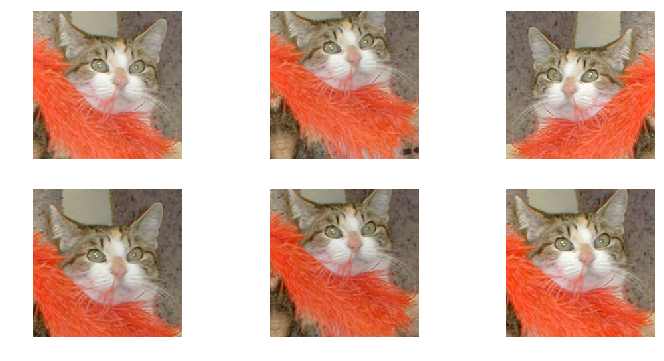

In [6]:
faplots.plots(ims, rows=2)

* Need to consider the right augmentations for your dataset.
  * `transforms_side_on` would be best for images generally taken from the side.
    * For cat photos, you probably wouldn't want to flip them vertically.
  * `transforms_top_down` may be better for images taken from the top, ie satellite imagery.

## 00:18:54 - Audience questions about learning rate finder

* Question 1: Why do we use the learning rate that's less than the lowest point?
* Answer 1: Want to find learning rate that's most likely to find the minimum. The one at the lowest point might jump close to the minimum, but will likely overshoot. The one just before that, should walk quickly to the minimum.

* Question 2: Do we need to find the best learning rate each epoch?
* Answer 2: Jeremy usually runs it once when it starts. If he unfreezes layers (covered later), he may run it again. Basically: if you change something in your model or how you train it, you'd rerun the finder.

## 00:24:10 - Data augmentations continued

* As well as the main two transformation lists, can create custom transform lists (covered later).
* When doing data aug, we are saying: "Based on our domain knowledge, here are different ways we can mess with the image and still understand what's in it".
* Now, when training the model, we can pass in the transforms:

In [8]:
data = dataset.ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

In [9]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.046287   0.02588    0.990234  



[0.025879795, 0.990234375]

* Initially, they won't do anything because of the `precompute=True` argument.
  * What it's doing:
    1. Caching the activations (a number) for every image: "precomputed activations".
    2. Now, we can use those cached values to speed up future epochs.
* In order to do it, need to set the precomputed to False:

In [10]:
learn.precompute = False

In [11]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.055033   0.025478   0.989746  
    1      0.037407   0.025497   0.990234                     
    2      0.043661   0.02586    0.991211                     



[0.025859684, 0.9912109375]

## 00:30:17 - Stochastic Gradient Descent with Restarts (SGDR)

* In the above example, we added `cycle_len=1` which enables a technique called *Stochastic Gradient Descent with Restarts*, which is a variant of *learning rate annealing*.
* Basic idea: as you get closer to the minima, you want to decrease your learning rate to ensure you get as close as possible to the minimum: called learning rate annealing.
* Standard approach is to pick a learning rate that works okay. Then, when your training stops improving, just decrease it.
* Better approach: pick some functional form for your learning rate, like a line or, even better, one half of a cosine curve.
  * At the top of the curve, when you are not very close, you have a high learning rate.
  * Then, as your training progresses, your rate starts to decrease quite rapidly.
  
    <img src="https://i.gyazo.com/0e3f9f1c7ab24dbd08c691ff725df903.gif" width=400px>

  * Called "cosign annealing".
* Because there can be lots of local minimas in high dimensional space, one approach is to have a learning rate that "jumps" occasionally.
  * This can get you out of a local minima, to the global minima.

## 00:35:40 - Audience questions about SGDR

* Question 1: Could you get the same effect (as cosign annealing) by training multiple models with different random initialisations, with the expectation that most of them will eventually explore the global minima?
* Answer 1: Before SGDR, people used to create ensembles, which is basically that approach. The advantage to SGDR, is that once you've found the local minima, you tend to hang around it, even if your learning rate increases, so you don't need the ensemble approach so much.
  * SGDR is Jeremy's "superpower"; usually gets him great results on Kaggle competitions.
  * Picking a reasonably high LR is a good idea, because you know the cosign annealing will gradually reduce the LR.
  
* Question 2: How many times do you change the learning rate per epoch?
* Answer 2: Learning rate is changed on each mini batch. Number of times it's reset, is defined by the `cycle_len` param. A value of 1 == one epoch, see below:

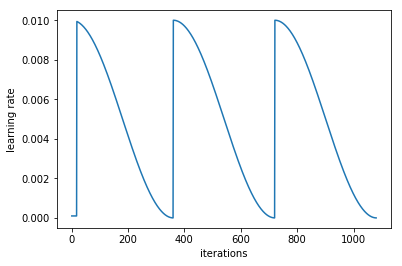

In [12]:
learn.sched.plot_lr()

* Question 3: Could you explain `precompute=True` - still confusing?
* Answer 3: Will be revisited later in the course.

* Question 4: Our main goal is to generalise. Are we keeping track of the minimas and averaging them or something?
* Answer 4: You could take the averages of the losses at each point where the learning rate is the lowest, but we're not doing that yet.
  * You could add `cycle_save_weights` param, which saves the weights at the end of each cycle for ensembling.

## 00:40:34 - Saving weights

* From time-to-time, you should save and load your weight as follows:

In [13]:
learn.save('224_lastlayer')

In [15]:
learn.load('224_lastlayer')

* When you save, create precomputed activations, resizing images, you are creating temporary files.
* Example of the data folder in dogsandcats: 

In [16]:
!ls data/dogscats/

models	sample	test1  tmp  train  valid


  * Note the existance of the `tmp` directory. All precomputed activations go in here.
    * If you are getting weird errors, might be worth deleting your `tmp` directory.

In [17]:
!ls data/dogscats/tmp/

x_act_resnet34_0_224.bc       x_act_test_resnet34_0_244.bc
x_act_resnet34_0_244.bc       x_act_val_resnet34_0_224.bc
x_act_test_resnet34_0_224.bc  x_act_val_resnet34_0_244.bc


  * The `model` directory is where you pretrained models go:

In [19]:
!ls data/dogscats/models/

224_lastlayer.h5  tmp.h5


## 00:42:35 - Audience question about weight caching

* Question 1: If I want to train my model from scratch, do I need to delete the precomputed activations?
* Answer 1: Not really, just create a new learn object - only delete if you have some error.

## 00:43:50 - Finetuning and differential learning rates

* Everything we've done so far hasn't changed the pretrained filter in early stages of network.
* If your pictures are quite different from ImageNet images, you may need to train earlier layers.
* To tell learner to train earlier layers, use `learn.unfreeze()`:

In [11]:
learn.unfreeze()

* Since the earlier layers probably don't need to change much, you most likely want to set a lower learning rate for earlier layers.
  * Can pass an array of learning rates:
    1. Position 1: first few layer learning rates.
    2. Position 2: middle learning layers.
    3. Position 3: added features.

In [12]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.048514   0.026359   0.989258  
    1      0.04       0.025339   0.989746                     
    2      0.029704   0.023698   0.98877                      
    3      0.028045   0.023565   0.991699                     
    4      0.024568   0.02078    0.993652                     
    5      0.02012    0.020977   0.992676                     
    6      0.02126    0.020534   0.992676                     



[0.02053412, 0.99267578125]

  * Doesn't have a name, Fast.ai calls it "differential learning rates".
* Above he's added a param `cycle_mult`, this doubles the length of a "cycle" after each cycle as follows:

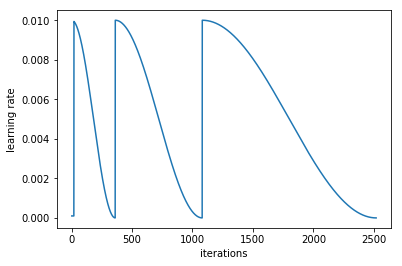

In [24]:
learn.sched.plot_lr()

In [25]:
learn.save('224_all')

In [13]:
learn.load('224_all')

## 00:55:28 - Audience questions on generalisation

* Question 1: Why does smoother surfaces correalte to more generalised networks?
* Answer 1: Idea of generalisation: if you give model a slightly different cat image, it should still predict a cat. The lowest minima should allow for that.

## 00:56:56 - Test time augmentation

* To make the images square, you'll generally just crop out the square in the middle of the image.
  * For some images, this could remove the context required to classify it.
* Solution: after you've trained the model, take 4 random data augmentations and the original image, then do a prediction for all. Take the average of all predictions and return that as the final predictions.
* To do that in Fast.AI, just call `TTA()`:

In [58]:
log_preds, y = learn.TTA()

In [62]:
probs = np.mean(np.exp(log_preds), axis=0)

In [64]:
def accuracy_np(preds, targs):
    preds = np.argmax(preds, 1)
    return (preds==targs).mean()

In [65]:
accuracy_np(probs, y)

0.995

  * TTA by default uses the validation set.

## 01:00:05 - Audience questions

* Question 1: ??
* Answer 1: During training, we aren't using TTA on the validation set.

* Question 2: Is there a high probabilty of having a sample in test time that wasn't seen during training?
* Answer 2: Yes. Every image that was data augmented will most likely be unique due to the number of possible permutations.

* Question 3: Why not use white padding or borders?
* Answer 3: Adding borders hasn't helped much in Jeremy's experiments.
  * Reflection padding can work well for stuff like satellite images.

* Question 4: How do you data augmentation with data that's not images?
* Answer 4: No one seems to know. In NLP, people have tried replacing synoymns, but not a lot of substantial research.

* Question 5: Couldn't you just use a sliding window over the image as an augmentation?
* Answer 5: Probably not useful during training, since you want tonnes of random augmentations. Fixed crops may be better during TTA - Jeremy's hasn't tried much.

* Question 6: Is the Fast.AI library open source?
* Answer 6: Yes. It sits on top of PyTorch, which itself is open source. PyTorch isn't very easy to use for beginners - hence Fast.AI.
  * Some limitations: if you want to do stuff on phones, you'll need to use Tensorflow.
  * Every year, the libraries tend to change. Important to know the concepts vs implementations.
  
* Question 7: Do you have an opinion on Pyro (Uber's new release)?
* Answer 7: Hasn't look at it, but interested in probabilistic programming.

## 01:11:50 - Deeper results analysis

* What does 99.65% accuracy mean?
* Useful to look at confusion matrix:
  * From the actual 1000 cats, how many did we think were dogs (and vice versa for dogs)?

In [76]:
preds = np.argmax(probs, 1)
probs = probs[:,1]

In [77]:
print(preds.shape)
print(probs.shape)

(2000,)
(2000,)


In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  5 995]]


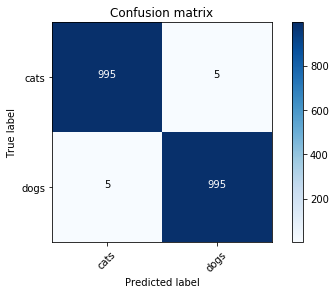

In [72]:
faplots.plot_confusion_matrix(cm, data.classes)

* In the above example, of the 1000 that are dogs, 5 were predicted as cats.
* Let's take a look a the bad predictions:

In [47]:
def plots(imgs, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
            plt.imshow(imgs[i])
    

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)


def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]


def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


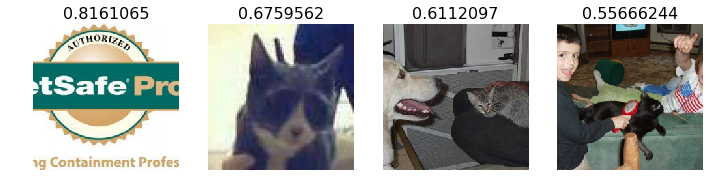

In [79]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect cats')

* Can see the first one isn't even a cat. The second appears to have a lot of artifacts.

Most incorrect dogs


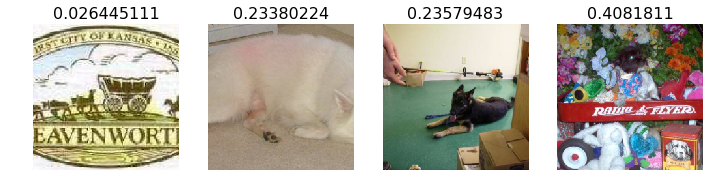

In [80]:
plot_val_with_title(most_by_correct(1, False), 'Most incorrect dogs')

## 01:14:10 - Basic steps to train a world-class image classifier (review)

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
  * If the problem is very different from ImageNet, then maybe want a higher learning rate for the earlier layers.
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting

## 01:16:39 - Walk through of steps on Dog Breed identification